In [1]:
import random

import cv2
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
tf.python.control_flow_ops = tf
%matplotlib inline


flags = tf.app.flags
FLAGS = flags.FLAGS

# command line flags
flags.DEFINE_integer('epochs', 5, "The number of epochs.")
flags.DEFINE_integer('batch_size', 128, "The batch size.")
LEFT_PERCENT = 1.0
RIGHT_PERCENT = 1.0
DATA_DIR = './data/'

# Read data
column_names = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
data = pandas.read_csv(DATA_DIR + 'driving_log.csv', skiprows=1, names=column_names)
center = data.center.tolist()
left = data.left.tolist()
right = data.right.tolist()
steering = data.steering.tolist()
center, left, right, steering = shuffle(center, left, right, steering)


Using TensorFlow backend.


ploting


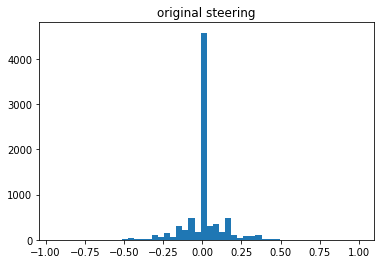

8036


In [2]:
def plot():
    print("ploting")
    plt.title('original steering')
    plt.hist(steering, bins=50)
    plt.show()
plot()
print(len(steering))

In [3]:
sorted_lists = sorted(zip(center, left, right, steering), key=lambda x: x[3])
s_c, s_l, s_r, s_s = [[x[i] for x in sorted_lists] for i in range(4)]

def preprocess_image(image):
    return cv2.resize(image[64:140, :], (80, 80))

def print_image(data):
    name = DATA_DIR + 'IMG/'+ data.split('/')[-1]
    original_image = cv2.imread(name)
    image = preprocess_image(original_image)
    plt.figure(figsize=(4,4))
    plt.imshow(image)

-0.5249807
-0.505992
-0.6294187
0.5784606
0.6454403000000001
0.5114809


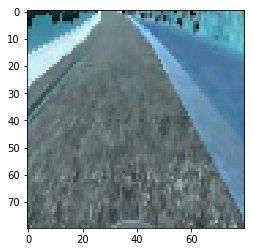

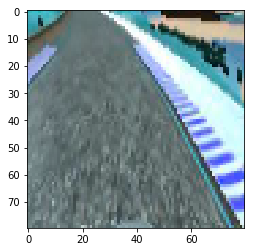

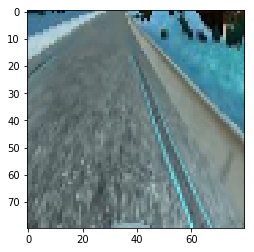

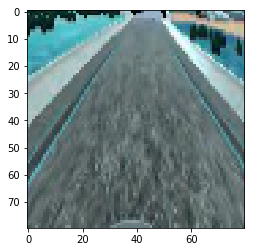

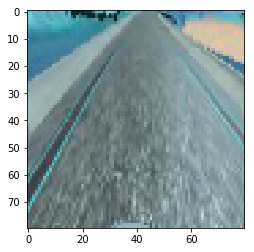

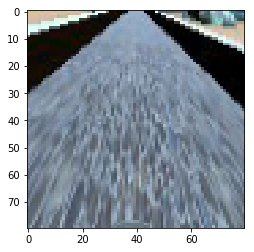

In [4]:
idx = random.sample(range(20), 3)
for i in idx:
    print_image(s_c[i])
    print(s_s[i])
idx = random.sample(range(len(s_s) - 20, len(s_s)), 3)
for i in idx:
    print_image(s_c[i])
    print(s_s[i])

In [5]:
limit = 500
steering_ids = []
for i, x in enumerate(steering):
    if abs(x) > 0.1:
        steering_ids.append(i)
    elif limit > 0 and x != 0.0:
        steering_ids.append(i)
        limit -= 1

print(len(steering_ids))
steering = [steering[i] for i in steering_ids]
left = [left[i] for i in steering_ids]
right = [right[i] for i in steering_ids]
center = [center[i] for i in steering_ids]

center, X_valid, steering, y_valid = train_test_split(center, steering, test_size=0.1)

nb_data = len(center)

left_indice = random.sample(range(nb_data), int(nb_data * LEFT_PERCENT))
right_indice = random.sample(range(nb_data), int(nb_data * RIGHT_PERCENT))

correction = 0.25

2613


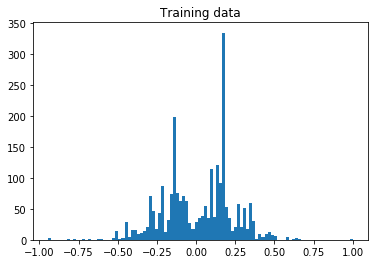

In [6]:
plt.title('Training data')
plt.hist(steering, bins=100)
plt.show()

In [7]:
left_angles = []
left_images = []
modified_left = []
for i in left_indice:
    # if steering[i] > 0.15:
    left_images.append(left[i])
    left_angles.append(steering[i] + correction)
    modified_left.append(i)

right_angles = []
right_images = []
modified_right = []
for i in right_indice:
    # if steering[i] < -0.15:
    right_images.append(left[i])
    right_angles.append(steering[i] - correction)
    modified_right.append(i)
        

-0.028127400000000025
0.5126991000000001
0.3596026
0.3787396
0.4457194
-0.1021233
-0.6705428
-0.1403974
-0.149966
-0.0734177


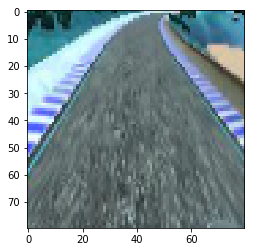

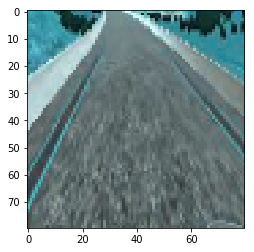

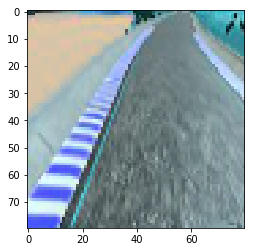

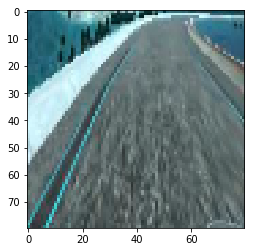

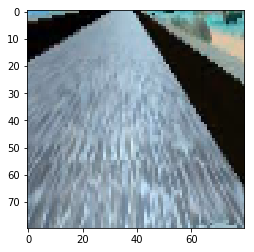

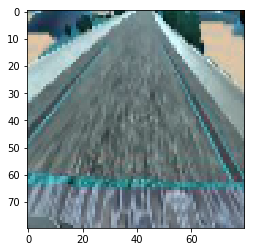

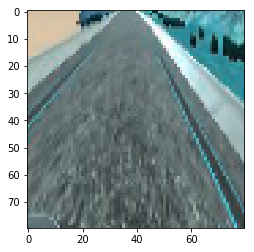

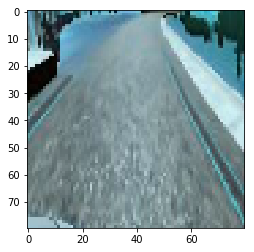

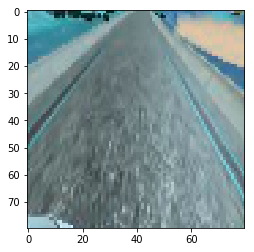

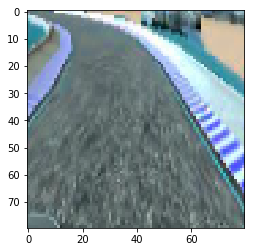

In [8]:
for i in modified_left[0:5]:
    print_image(left[i])
    print(steering[i] + correction)
for i in modified_right[0:5]:
    print_image(right[i])
    print(steering[i] - correction)

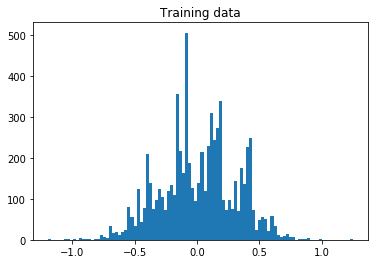

In [9]:
X_train = center + left_images + right_images
y_train = steering + left_angles + right_angles
# X_train = center
# y_train = steering
X_train, y_train = shuffle(X_train, y_train)


plt.title('Training data')
plt.hist(y_train, bins=100)
plt.show()

In [10]:
def plot_test():
    tmp_steerings = []
    for ephch in range(5):
        for i in range(len(X_train)):
            name = DATA_DIR + 'IMG/'+ X_train[i].split('/')[-1]
            original_image = cv2.imread(name)
            center_image = preprocess_image(original_image)
            center_angle = float(y_train[i])

            flip_coin = random.randint(0, 1)
            if flip_coin == 1:
                center_image, center_angle = flip(center_image, center_angle)
            trans = random.randint(0, 1)
            if trans:
                center_image, center_angle = translate(center_image, center_angle)
            tmp_steerings.append(center_angle)
    plt.title('test new data')
    plt.hist(tmp_steerings, bins=100)
    plt.show()


def flip(image, angle):
    new_image = cv2.flip(image, 1)
    new_angle = angle * -1
    return new_image, new_angle

TRANS_X_RANGE = 100
TRANS_Y_RANGE = 40
TRANS_ANGLE = 0.5


def translate(img, angle):
    """
    Shifts an image vertically and horizontally
    by a randaom amount.abs
    New angle is computed accordingly.
    """
    x_translation = (TRANS_X_RANGE * np.random.uniform()) - (TRANS_X_RANGE / 2)
    new_angle = angle + ((x_translation / TRANS_X_RANGE) * 2) * TRANS_ANGLE
    y_translation = (TRANS_Y_RANGE * np.random.uniform()) - (TRANS_Y_RANGE / 2)
    translation_matrix = np.float32([[1, 0, x_translation], [0, 1, y_translation]])
    return cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0])), new_angle



    
def test_image(i=0):
    name = DATA_DIR + 'IMG/' + X_train[i].split('/')[-1]
    original_image = cv2.imread(name)
    plt.imshow(original_image)
    plt.savefig('orig.png')

    center_image = preprocess_image(original_image)
    center_angle = float(y_train[i])

    plt.imshow(center_image)
    plt.savefig('preprocess.png')

    flip_coin = random.randint(0, 1)
    if flip_coin == 1:
        center_image, center_angle = flip(center_image, center_angle)
    plt.imshow(center_image)
    plt.savefig('flip.png')
    plt.show()


def generator(X, y, batch_size=64):
    num_samples = len(X)
    X, y = shuffle(X, y)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_X = X[offset:offset+batch_size]
            batch_y = y[offset:offset+batch_size]

            images = []
            angles = []
            for i in range(len(batch_X)):
                name = DATA_DIR + 'IMG/'+ X[i].split('/')[-1]
                center_image = cv2.imread(name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                center_angle = float(batch_y[i])

                flip_coin = random.randint(0, 1)
                if flip_coin == 1:
                    center_image, center_angle = flip(center_image, center_angle)
                trans = random.randint(0, 1)
                trans = 0
                if trans:
                    center_image, center_angle = translate(center_image, center_angle)
                threshold = np.random.uniform()
                # If the newly augmented angle + the bias falls below the threshold
                # then discard this angle / img combination and look again
                if abs(center_angle) * 3 < threshold:
                     continue
                center_image = preprocess_image(center_image)
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            cur_X_train = np.array(images)
            cur_y_train = np.array(angles)
            yield shuffle(cur_X_train, cur_y_train)

# compile and train the model using the generator function
train_generator = generator(center, steering, batch_size=32)
validation_generator = generator(X_valid, y_valid, batch_size=32)

if __name__ == "__main__":
    # plot_test()
    plt.ion()
    # test_image()
    # exit(0)
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(80, 80, 3)))
    model.add(Convolution2D(1,1,1, border_mode ='same',init='glorot_uniform'))
    model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(2,2)))
    model.add(Activation('relu'))
    model.add(Convolution2D(36, 5, 5, border_mode='valid', subsample=(2,2)))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(2,2)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.5))
    model.add(Dense(50))
    model.add(Dense(20))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=0.0001), loss='mse', metrics=['accuracy'])
    model.summary()

    model.fit_generator(train_generator, validation_data=validation_generator,
                        nb_epoch=FLAGS.epochs, samples_per_epoch=len(X_train),
                        nb_val_samples=len(X_valid))

    model.save('model.h5')
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 80, 80, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 80, 80, 1)     4           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 38, 38, 24)    624         convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 38, 38, 24)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

/Users/greenmoon55/anaconda/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


7067/7053 [==============================] - 52s - loss: 0.0770 - acc: 0.0000e+00 - val_loss: 0.0681 - val_acc: 0.0000e+00
Epoch 2/5
7057/7053 [==============================] - 54s - loss: 0.0768 - acc: 0.0000e+00 - val_loss: 0.0675 - val_acc: 0.0000e+00